# Geothermal energy extraction
Here I solve the equations for nonisothermal flow in porous media. The equations will be solved with different assumptions:
  + Viscosity does not change with temperature
  + Viscosity is a function of temperature
  
The domains are:
  + 1D linear
  + 1D radial
  + 2D
  + 3D

In [3]:
% start the FVTool
cd('/home/ali/MyPackages/FVTool/');
FVToolStartUp()

AGMG 3.x linear solver is NOT available.
FiniteVolumeToolbox has started successfully.


In [4]:
function p_val=continuity(m, q)
mu_val=1e-3; % (Pa.s)
poros=0.2;
perm_val=1.0e-12; % (m^2)
% physical system
p_out=250e5; % (Pa)
% assign values to the domain
k=createCellVariable(m, perm_val);
labda_face=harmonicMean(k/mu_val);
phi=createCellVariable(m,poros);
% Define the boundaries
BCp = createBC(m); % Neumann BC for pressure
BCc = createBC(m); % Neumann BC for concentration
% change the right boandary to constant pressure (Dirichlet)
BCp.right.a(:)=0.0;
BCp.right.b(:)=1.0;
BCp.right.c(:)=p_out;
% left boundary
BCp.left.a(:)=0.0;
BCp.left.b(:)=1.0;
BCp.left.c(:)=p_out;
Mdiffp=diffusionTerm(labda_face);
[Mbcp, RHSbcp] = boundaryCondition(BCp);
RHSsp=constantSourceTerm(q);
Mp= Mdiffp+Mbcp;
RHSp=RHSsp+RHSbcp;
p_val=solvePDE(m, Mp, RHSp);
end

function [p,T]=geotherm_iso(m, p)
end

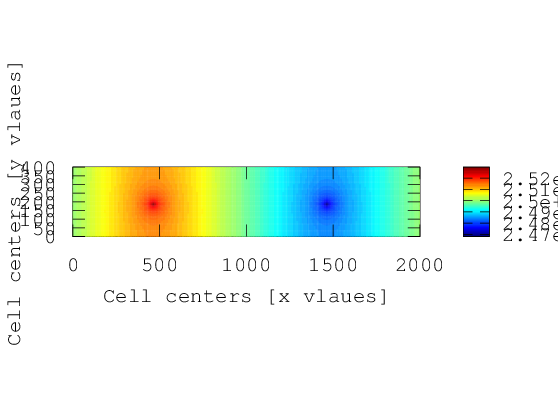

In [27]:
Nx=100;
Ny=50;
Nz=1;
Lx=2000;
Ly=400;
Lz=100;
v_cell=(Lx*Ly*Lz)/(Nx*Ny*Nz)
qin=100/3600; %[m^3/s]
m=createMesh2D(Nx,Ny, 2000, 400);
q=createCellVariable(m, 0.0);
q.value(25,25)=-qin/v_cell;
q.value(75,25)=qin/v_cell;
p=continuity(m, q);
visualizeCells(p)
shading interp

In [28]:
max(p.value(:))

ans =    2.5298e+07


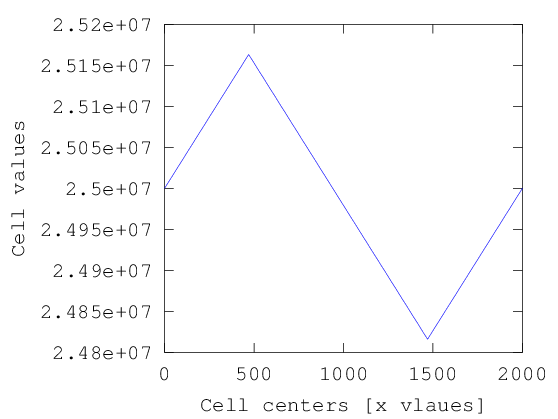

In [29]:
Nx=100;
Ny=1;
Nz=1;
Lx=2000;
Ly=400;
Lz=100;
v_cell=(Lx*Ly*Lz)/(Nx*Ny*Nz)
qin=100/3600; %[m^3/s]
m=createMesh1D(Nx, Lx);
q=createCellVariable(m, 0.0);
q.value(25)=-qin/v_cell;
q.value(75)=qin/v_cell;
p=continuity(m, q);
visualizeCells(p)

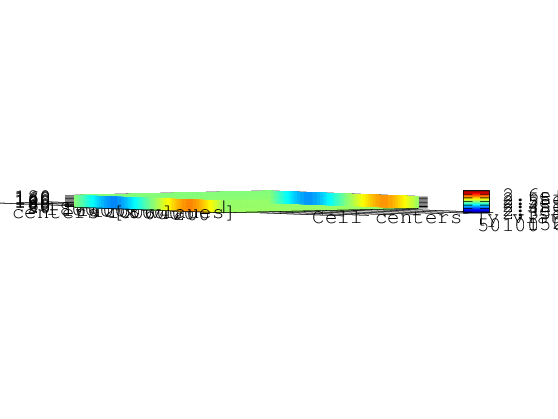

In [42]:
Nx=100;
Ny=50;
Nz=10;
Lx=2000;
Ly=400;
Lz=200;
v_cell=(Lx*Ly*Lz)/(Nx*Ny*Nz)
qin=100/3600; %[m^3/s]
m=createMesh3D(Nx,Ny,Nz, Lx, Ly, Lz);
q=createCellVariable(m, 0.0);
q.value(25,25,:)=-qin/v_cell;
q.value(75,25,:)=qin/v_cell;
p=continuity(m, q);
visualizeCells(p)
%shading interp